<a href="https://colab.research.google.com/github/johnkevinoregan/Learning-Relations-with-Deep-Learning/blob/main/brightness_generalisation_on_1d_retina_dont_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bright/Dark judgement on 1D retina: generalization to untrained retinal locations and untrained brightnesses
*PLEASE DON'T CHANGE THIS NOTEBOOK -- MAKE A COPY!*

---

##Functions used to create training examples

In [ ]:
#K Generate training samples for Brightness judgement
#PixToSkip is the number of retinal pixels inbetween two successive retinal locations where there can be a training sample. You can use the value 0 if you dont want to skip locations.
#LeftNumToTrain is the number of retinal locations on the left side of the retina you want to train
#NumInHole is the number of those retinal locations in the center of the retina where you choose not to train (in order to test generalization)
#RightNumToTrain is the number of retinal locations on the right side of the retina you want to train
#As an example : generate_training_set(0,4,0,4) generates a training set with a retina of size 8 where all locations will be trained (+'s) and there is no hole: ++++++++ 
#generate_training_set(0,4,3,4) does the same except now there is a hole where there is no training (.'s): ++++...++++ (the retina is now of length 11)
#generate_training_set(1,4,3,4) does the same again, except now there are also skipped pixels inbetween all the training locations: +.+.+.+......+.+.+.+

#For this brightness task, each retinal locations gets 1 example with high brightness, and 1 with low brightness. 
#At each retinal location, the array X_locs_trained[] is updated by 0.5 for each brightness, so should equal 1 if the arrays are properly filled.

#NB at first I had a background of 0's. I found that in that case there was a bias to give a good prediction to dim pixels. In untrained locations there was therefore a tendency to incorrectly report bright pixels as dim.
#But putting a background of 125 and making dim and bright symmetrically placed with respect to that middle value, things became more reasonable.

def generate_bright_training_set(BackGround,Brightnesses,PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain): 
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  LastRetinaPixel=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)
  Midpoint=LastRetinaPixel/2
  #print(Midpoint)
  X_trials=[[BackGround for col in range(LastRetinaPixel+1)] for row in range(2*TotNumToTrain)]
  X_locs_trained=[0 for col in range(LastRetinaPixel+1)]
  StepInterval=PixToSkip+1
  i=0
  for b in range(0,2):
    #print('b', b)
    for j in range(LeftNumToTrain):
      RetPos=j*StepInterval
      #print(i,RetPos)
      X_trials[i][RetPos]=Brightnesses[b]
      X_locs_trained[RetPos]+=0.5
      #print(X_trials[i])
      i+=1
      #print('left')
    for j in range(RightNumToTrain):
      RetPos=(LeftNumToTrain+NumInHole+j)*StepInterval
      #print(i,RetPos)
      X_trials[i][RetPos]=Brightnesses[b]
      X_locs_trained[RetPos]+=0.5
      #print(X_trials[i])
      i+=1
      #print('right')

  return(X_trials,X_locs_trained)

#K This function generates a list of all the possible tests for brightness judgements
#you must give it exactly the same parameters as for the training set so it can calculate how long the retina is
#even though for the test it actually has no holes or skipped pixels at all.
def generate_bright_test_set(BackGround,Brightnesses,PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain):
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  RetinaSize=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)+1
  AllPossTests=[[BackGround for row in range(RetinaSize)] for col in range(2*RetinaSize)]
  for b in range(0,2):
    #print('b',b)
    for i in range(RetinaSize):
      AllPossTests[i+b*RetinaSize][i]=Brightnesses[b]
  return(AllPossTests)

# K generate labels based on the index of 1 in each row of the Training or Test set
def generate_bright_labels(Brightnesses,Set):
  Labels=[0 if Brightnesses[0] in row else 1 for row in Set]
  
 # Labels=[0 for col in range(len(Set))]
 # for i in range(len(Set)):
 #   if max(Set[i])==Brightnesses[0]:
 #     Labels[i]=0
 #   else:
 #     Labels[i]=1
  #Labels=[0 if max(row)==Brightnesses[0] else 1 for row in Set]
  return Labels


##Make training sets X_train and labels y_train

In [ ]:
BackGround=125
Brightnesses=[125-62,125+62]
skip=0
left=5
hole=10
right=5

X_train,X_locs_trained=generate_bright_training_set(BackGround,Brightnesses,skip,left,hole,right)

#If we dont shuffle the training set, there may be a left-right sequence bias on the training.
import numpy as np
np.random.shuffle(X_train)
y_train=generate_bright_labels(Brightnesses,X_train)
print('locations trained')
print(X_locs_trained)
print()

print('training set')
for i in range(len(X_train)):
  print(X_train[i], 'label',y_train[i])
print()



## Train with normal NN

In [ ]:
# Build, compile and train the neural network model
#there are two hidden layers with 64 and 32 values
#The ReLU activation function is used in deep learning models to introduce non-linearity into the network
#the sigmoid activation function produces a probability value between 0 and 1
from tensorflow import keras
import numpy as np
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.callbacks import EarlyStopping


model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_dim=len(X_train[0])),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))
model.fit(X_train, y_train, epochs=200, batch_size=32)




###Test normal NN 
Check for generalization to:
- untrained retinal positions
- and  at 2 delta values on either side of original brightness levels

locations trained


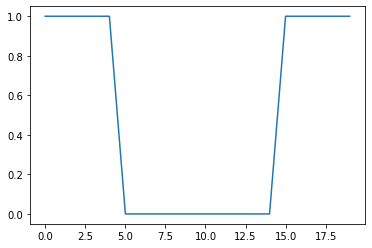

trained Brightnesses: [63, 187] tested with [18, 232] Delta: -45


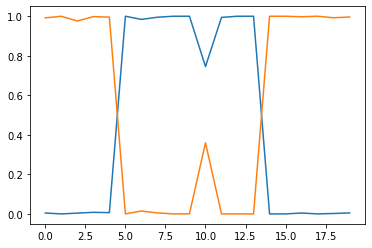

trained Brightnesses: [63, 187] tested with [33, 217] Delta: -30


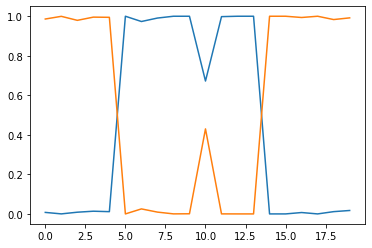

trained Brightnesses: [63, 187] tested with [48, 202] Delta: -15


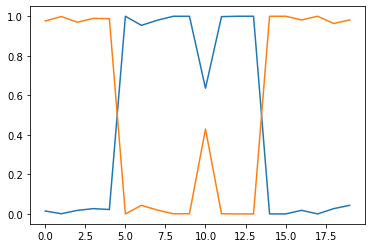

trained Brightnesses: [63, 187] tested with [63, 187] Delta: 0


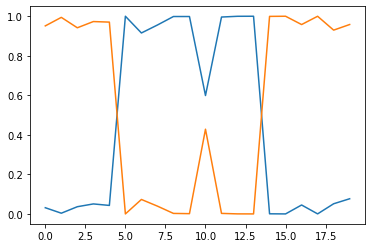

trained Brightnesses: [63, 187] tested with [78, 172] Delta: 15


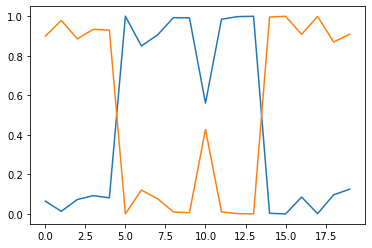

trained Brightnesses: [63, 187] tested with [93, 157] Delta: 30


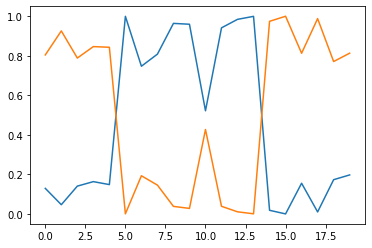

trained Brightnesses: [63, 187] tested with [108, 142] Delta: 45


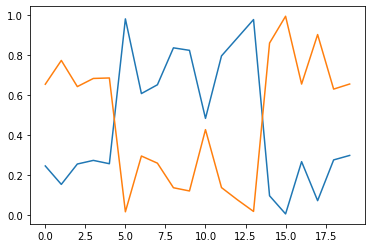

In [ ]:
print('locations trained')
plt.plot(X_locs_trained)
plt.show()

for BrightDelta in range(-45,46,15):
  temp=np.add(Brightnesses,[BrightDelta,-BrightDelta])
  BrightnessesChanged=temp.tolist()

  X_test=generate_bright_test_set(BackGround,BrightnessesChanged,skip,left,hole,right)
  y_test=generate_bright_labels(BrightnessesChanged,X_test)
  #print('test set')
  #for i in range(len(X_test)):
  #  print(X_test[i], 'label',y_test[i])
  #print()


  #Test on all retinal positions including non-trained ones
  # We plot separately the predictions for the two brightness levels at each RetPos
  NumTrials=len(X_test)
  RetinaSize=len(X_test[0])
  resultsNN=[[0 for row in range(0,2)] for col in range(RetinaSize)]
  for trial in range(NumTrials):
    pred=model.predict(np.array([X_test[trial]]), verbose=0)
    estimate=pred[0][0]
    bright=BrightnessesChanged[y_test[trial]]
    which=BrightnessesChanged.index(bright)
    RetPos=X_test[trial].index(bright)
    #print(which,RetPos,estimate)
    resultsNN[RetPos][which]=estimate
  #print(resultsNN)
  print('trained Brightnesses:',Brightnesses, 'tested with',BrightnessesChanged,'Delta:', BrightDelta)

  import matplotlib.pyplot as plt
  #plt.suptitle('BrightDelta',BrightDelta)
  plt.plot(resultsNN)
  plt.show()





Comment on results:
- concerning generalization to non-trained locations in the "hole" in the middle of the retina: curiously the NN doesnt do randomly at these, but *inverts* its estimates compared to the left and right regions where training occurs.
- concerning generalization to untrained brightnesses: when the test brightnesses are closer to the extremes of 0 and 255 the NN interestingly does better than for the trained values of [63,187]. When the test brightnesses are closer to the background value of 125, the NN does worse.

## Train with CNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(len(X_train[0]), 1)))
model.add(MaxPooling1D(pool_size=4))
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=1)

#loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy:", accuracy)

###Test CNN 
Check for generalization to:
- untrained retinal positions
- and  at 2 delta values on either side of original brightness levels

locations trained


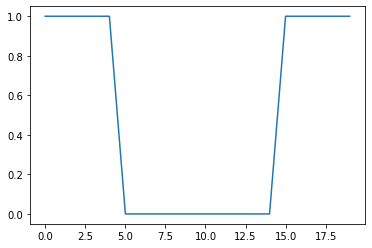

trained Brightnesses: [63, 187] tested with [18, 232] Delta: -45


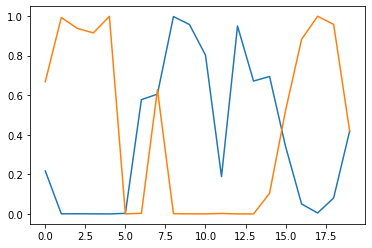

trained Brightnesses: [63, 187] tested with [33, 217] Delta: -30


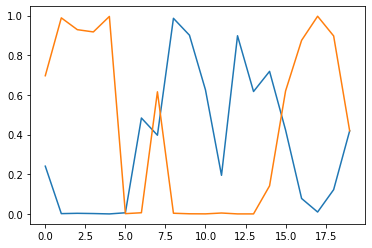

trained Brightnesses: [63, 187] tested with [48, 202] Delta: -15


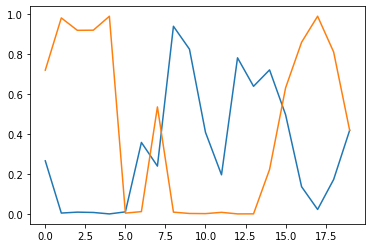

trained Brightnesses: [63, 187] tested with [63, 187] Delta: 0


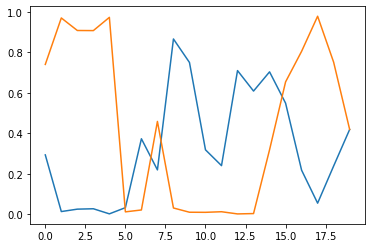

trained Brightnesses: [63, 187] tested with [78, 172] Delta: 15


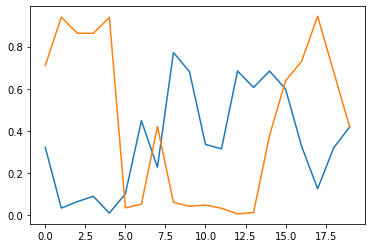

trained Brightnesses: [63, 187] tested with [93, 157] Delta: 30


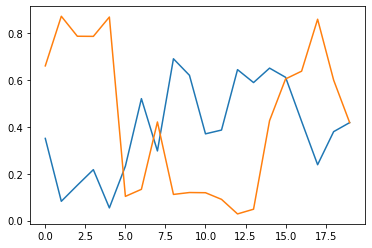

trained Brightnesses: [63, 187] tested with [108, 142] Delta: 45


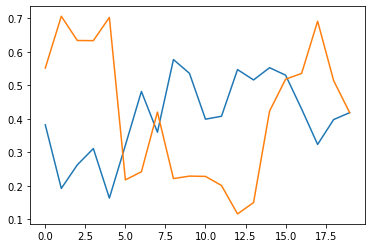

In [ ]:
print('locations trained')
plt.plot(X_locs_trained)
plt.show()

for BrightDelta in range(-45,46,15):
  temp=np.add(Brightnesses,[BrightDelta,-BrightDelta])
  BrightnessesChanged=temp.tolist()

  X_test=generate_bright_test_set(BackGround,BrightnessesChanged,skip,left,hole,right)
  y_test=generate_bright_labels(BrightnessesChanged,X_test)
  #print('test set')
  #for i in range(len(X_test)):
  #  print(X_test[i], 'label',y_test[i])
  #print()


  #Test on all retinal positions including non-trained ones
  # We plot separately the predictions for the two brightness levels at each RetPos
  NumTrials=len(X_test)
  RetinaSize=len(X_test[0])
  resultsCNN=[[0 for row in range(0,2)] for col in range(RetinaSize)]
  for trial in range(NumTrials):
    pred=model.predict(np.array([X_test[trial]]), verbose=0)
    estimate=pred[0][0]
    bright=BrightnessesChanged[y_test[trial]]
    which=BrightnessesChanged.index(bright)
    RetPos=X_test[trial].index(bright)
    #print(which,RetPos,estimate)
    resultsCNN[RetPos][which]=estimate
  #print(resultsNN)
  print('trained Brightnesses:',Brightnesses, 'tested with',BrightnessesChanged,'Delta:', BrightDelta)

  import matplotlib.pyplot as plt
  #plt.suptitle('BrightDelta',BrightDelta)
  plt.plot(resultsCNN)
  plt.show()



Comment on results:
The CNN (here with kernel and Maxpooling size 4) predictions get worse as brightnesses approach the background level of 125 and better than the trained performance if you make the brightnesses used approach the extremes of [0,255].

The generalization to untrained retinal locations doesnt really occur: rather, untrained locations seem to obtain a bias for responses there to be in the opposite direction to trained locations.